# Import packages and creation of DataFrames

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import pytz
from datetime import time

In [3]:
from running.run import Run

# df -> granularity by minute of each run
df = Run().get_total_runs()

# df_agg -> granularity by run
df_agg = Run().get_agg_runs()

In [4]:
# Colors

PURPLE = "#A361F2"
ORANGE = "#F59762"
GRAY = "#515151"
GREEN = '#919B81'
BLUE = '#789CF0'
BROWN = '#635B4F'
LIGHT_GREEN = '#42E36F'

# Exploratory Analysis

## Speed and Pace over time

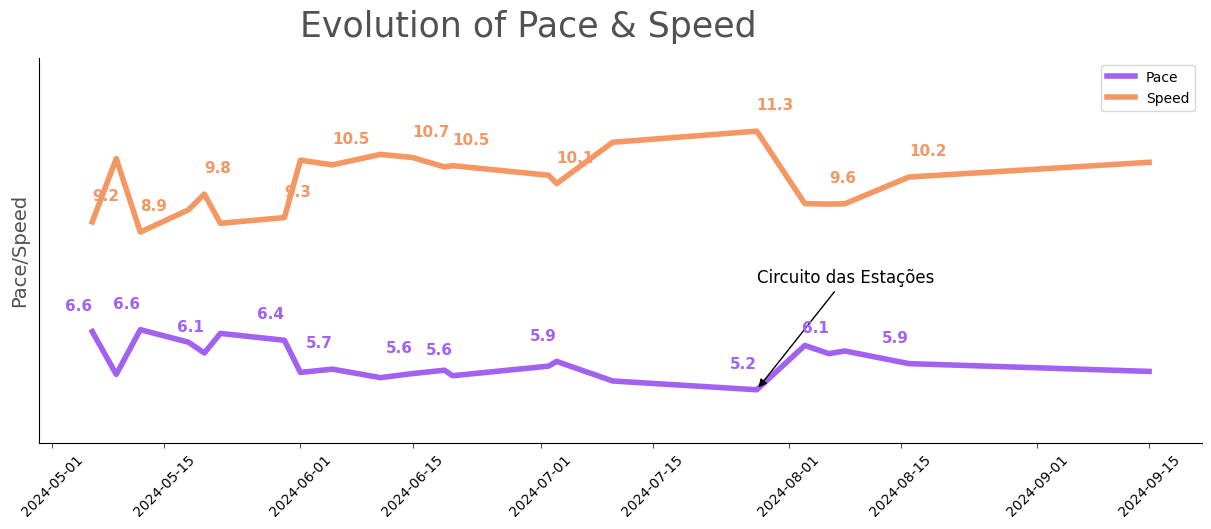

In [5]:
fig, ax = plt.subplots(figsize = (15, 5))

ax.plot(df_agg['date'], df_agg['pace'], color=PURPLE, linewidth=4, label='Pace')
ax.plot(df_agg['date'], df_agg['speed'], color=ORANGE, linewidth=4, label='Speed')

index = df_agg[df_agg['date'] == '2024-07-28'].index[0]

x = df_agg['date'][index]
y = df_agg['pace'][index]

ax.spines[['right', 'top']].set_visible(False)

ax.set_yticks([])
ax.set_ylabel('Pace/Speed', fontsize=14, color=GRAY)
ax.tick_params(axis='y', labelsize=12, color=GRAY)
ax.tick_params(axis='x', rotation=45, color=GRAY)
ax.set_ylim(4, 13)

ax.annotate(
    'Circuito das Estações', 
    xy=(x, y),
    xytext=(x, y + 2.5),
    arrowprops=dict(facecolor='black', arrowstyle='-|>'),  # Estilo da seta
    fontsize=12,
    color='black'
)

for i in range(0, len(df_agg), 2):
    ax.text(
        df_agg['date'][i], df_agg['pace'][i] + 0.5, f'{df_agg["pace"][i]:.1f}', fontsize=11, fontweight='bold', color=PURPLE, ha='right'
    )
    ax.text(
        df_agg['date'][i], df_agg['speed'][i] + 0.5, f'{df_agg["speed"][i]:.1f}', fontsize=11, fontweight='bold', color=ORANGE, ha='left'
    )

ax.text(df_agg['date'].min() + pd.Timedelta(days=26), 13.5, 'Evolution of Pace & Speed', fontsize=25, color=GRAY)

ax.legend()

plt.show()

## Distance

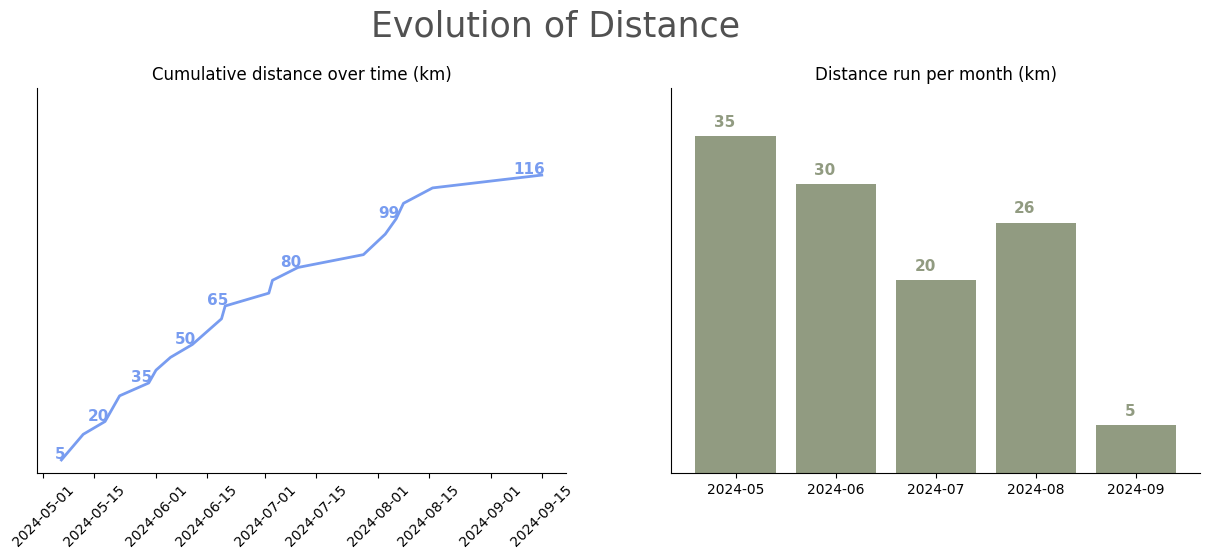

In [6]:
df_agg['month'] = df_agg['date'].apply(lambda x: str(x)[0:7])

df_agg_monthly = df_agg.groupby('month', as_index=False).agg({'km':'sum'})

fig, axs = plt.subplots(1, 2, figsize = (15, 5))


axs[0].plot(df_agg['date'], df_agg['cum_km'], color=BLUE, linewidth=2)
axs[0].tick_params(axis='x', rotation=45)
axs[0].set_title('Cumulative distance over time (km)')
axs[0].set_ylim(0, 150)
axs[0].spines[['right', 'top']].set_visible(False)
axs[0].set_yticks([])
for i in range(0, len(df_agg), 3):
    axs[0].text(
        df_agg['date'][i]+pd.Timedelta(days=1), df_agg['cum_km'][i] + 0.5, f'{df_agg["cum_km"][i]:.0f}', fontsize=11, fontweight='bold', color=BLUE, ha='right'
    )


axs[1].bar(df_agg_monthly['month'], df_agg_monthly['km'], color=GREEN)
axs[1].set_title('Distance run per month (km)')
axs[1].set_ylim(0, 40)
axs[1].spines[['right', 'top']].set_visible(False)
axs[1].set_yticks([])
for i in range(0, len(df_agg_monthly)):
    axs[1].text(
        df_agg_monthly['month'][i], df_agg_monthly['km'][i] + 1, f'{df_agg_monthly["km"][i]:.0f}', fontsize=11, fontweight='bold', color=GREEN, ha='right'
    )

axs[0].text(df_agg['date'].min() + pd.Timedelta(days=85), 170, 'Evolution of Distance', fontsize=25, color=GRAY)

plt.show()

## Pace per km

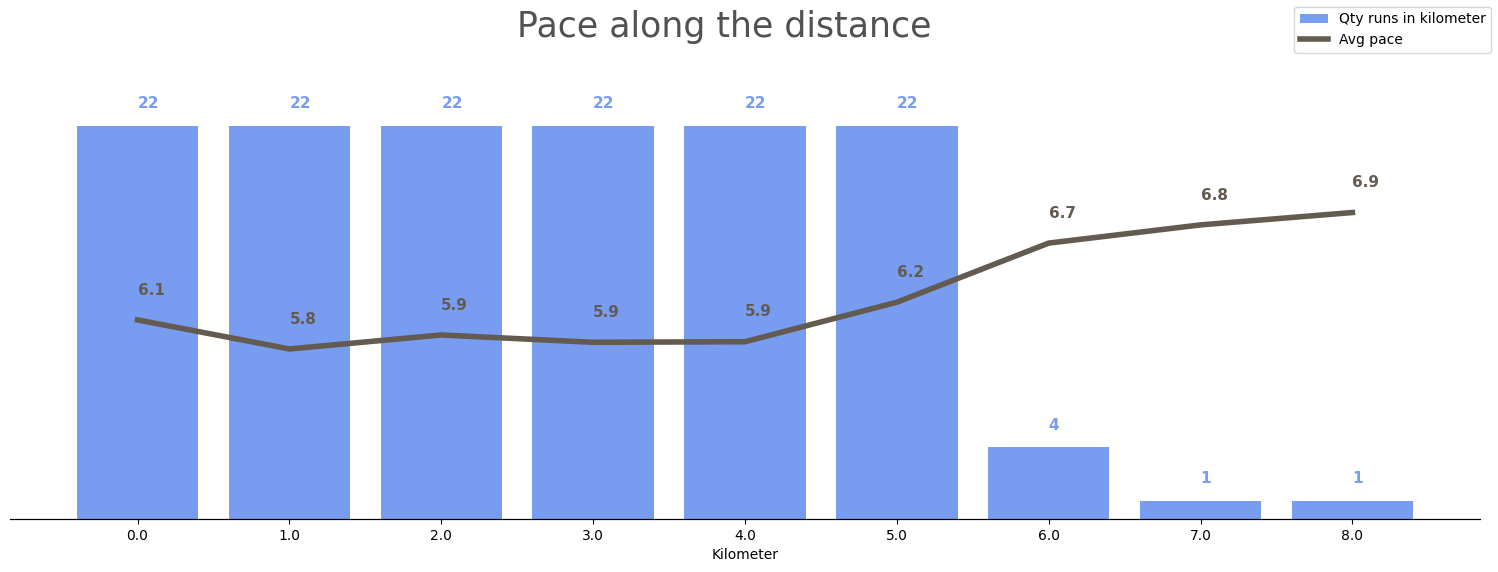

In [7]:
pace_per_km = df.groupby('km', as_index=False).agg({'pace':'mean', 'id':'nunique'})

fig, ax1 = plt.subplots(figsize=(15,5))

ax1.bar(pace_per_km['km'], pace_per_km['id'], color=BLUE, label='Qty runs in kilometer')
ax1.set_ylim(0, 25)
ax1.spines[['right', 'top', 'left']].set_visible(False)
ax1.set_yticks([])
ax1.set_xticks(range(len(pace_per_km['km'])))
ax1.set_xticklabels(pace_per_km['km'])
fig.tight_layout()

for i in range(0, len(pace_per_km)):
    ax1.text(
        pace_per_km['km'][i], pace_per_km['id'][i]+1, f"{pace_per_km['id'][i]:.0f}", fontsize=11, fontweight='bold', color=BLUE
    )


ax2 = ax1.twinx()
ax2.plot(pace_per_km['km'], pace_per_km['pace'], color=BROWN, label='Avg pace', linewidth=4)
ax2.set_ylim(4.5, 8)
ax2.spines[['right', 'top', 'left']].set_visible(False)
ax2.set_yticks([])
for i in range(0, len(pace_per_km)):
    ax2.text(
        pace_per_km['km'][i], pace_per_km['pace'][i]+0.2, f"{pace_per_km['pace'][i]:.1f}", fontsize=11, fontweight='bold', color=BROWN
    )

ax1.set_xlabel('Kilometer')
fig.legend()

ax1.text(pace_per_km['km'].mean()-1.5, pace_per_km['id'].max()+5, 'Pace along the distance', fontsize=25, color=GRAY)
plt.show()

## Part of the day

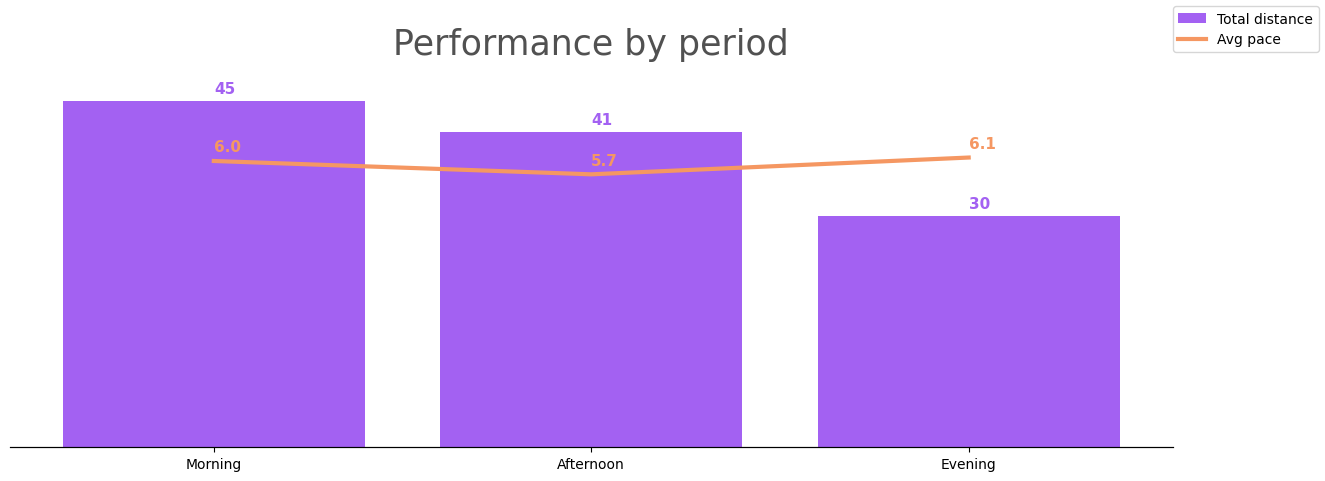

In [17]:
fig, ax1 = plt.subplots(figsize=(15, 5))

df_period_of_day = df_agg.groupby('period', as_index=False).agg({'km':'sum', 'pace':'mean'})
df_period_of_day.columns = ['period', 'total_distance', 'avg_pace']
period_dict = {'Morning':1, 'Afternoon':2, 'Evening':3}

df_period_of_day['order_period'] = df_period_of_day['period'].map(period_dict)
df_period_of_day = df_period_of_day.sort_values('order_period')

ax1.bar(df_period_of_day['period'], df_period_of_day['total_distance'], color=PURPLE, label='Total distance')
ax1.spines[['right', 'top', 'left']].set_visible(False)
ax1.set_yticks([])

for i in range(0, len(df_period_of_day)):
    ax1.text(
        df_period_of_day['period'][i], 
        df_period_of_day['total_distance'][i] + 1, 
        f"{df_period_of_day['total_distance'][i]:.0f}", 
        fontsize=11, fontweight='bold', color=PURPLE
    )

ax2 = ax1.twinx()
ax2.plot(df_period_of_day['period'], df_period_of_day['avg_pace'], color=ORANGE, linewidth=3, label='Avg pace')
ax2.spines[['right', 'top', 'left']].set_visible(False)
ax2.set_yticks([])

for i in range(0, len(df_period_of_day)):
    ax2.text(
        df_period_of_day['period'][i], 
        df_period_of_day['avg_pace'][i] + 0.2, 
        f"{df_period_of_day['avg_pace'][i]:.1f}", 
        fontsize=11, fontweight='bold', color=ORANGE
    )

ax1.set_ylim(0, df_period_of_day['total_distance'].max() + 5)
ax2.set_ylim(0, df_period_of_day['avg_pace'].max() + 2)

ax1.set_title('Performance by period', fontsize=25, color=GRAY)

fig.legend()

plt.show()

# Statistics

## Shape of the curve

In [ ]:
fig, ax = plt.subplots(figsize=(10,3))

sns.histplot(df['pace'], kde=True, ax=ax);

In [ ]:
mu = df["pace"].mean()
sigma = df["pace"].std()
skew = df["pace"].skew()
kurtosis = df["pace"].kurtosis()

print(f"Mean: {mu:.2f}")
print(f"Std: {sigma:.2f}")
print(f"Skewness: {skew:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

## Statistical Tests

### Period

In [ ]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

import scipy.stats as stats

In [ ]:
shapiro_results = {}
for period in df['period'].unique():
    group_data = df[df['period'] == period]['pace']
    stat, p_value = stats.shapiro(group_data)
    shapiro_results[period] = (stat, p_value)

for period, (stat, p_value) in shapiro_results.items():
    print(f"Period: {period}, Statistics: {stat:.3f}, p-value: {p_value}")

In [ ]:
groups = [df[df['period'] == period]['pace'] for period in df['period'].unique()]

kruskal_stat, kruskal_p_value = stats.kruskal(*groups)

print(f"Kruskal-Wallis test statistic: {kruskal_stat:.3f}, p-value: {kruskal_p_value}")

### Kilometer mark

In [ ]:
shapiro_results = {}

df_km = df.query("km < 7")

for km in df_km['km'].unique():
    group_data = df_km[df_km['km'] == km]['pace']
    stat, p_value = stats.shapiro(group_data)
    shapiro_results[km] = (stat, p_value)

for km, (stat, p_value) in shapiro_results.items():
    print(f"Km: {km}, Statistics: {stat:.3f}, p-value: {p_value}")

In [ ]:
groups = [df_km[df_km['km'] == km]['pace'] for km in df_km['km'].unique()]

kruskal_stat, kruskal_p_value = stats.kruskal(*groups)

print(f"Kruskal-Wallis test statistic: {kruskal_stat:.3f}, p-value: {kruskal_p_value}")

## Probabilities for paces

In [ ]:
target_mean = 5.8
n = 100

X_bar = stats.norm(mu, sigma/np.sqrt(n))

x = np.linspace(4, 8, 100)
y = X_bar.pdf(x)

plt.plot(x, y)
plt.scatter(target_mean, X_bar.pdf(target_mean), c='r')

plt.show()

In [ ]:
X_bar.cdf(target_mean) * 100

In [ ]:
true_norm = stats.norm(0, 1)

z = (target_mean - mu) / (sigma / np.sqrt(n))
x = np.linspace(-4, 4, 100)\

y = true_norm.pdf(x)

plt.plot(x, y)
plt.scatter(z, true_norm.pdf(z), c='r')

plt.show()

In [ ]:
true_norm.cdf(z) * 100

In [ ]:
mu

In [ ]:
sigma

In [ ]:
sigma/np.sqrt(100)